In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Populating the interactive namespace from numpy and matplotlib


In [23]:
import os
import pickle
import pandas as pd
from tqdm import tqdm
from allensdk.core.cell_types_cache import CellTypesCache

In [30]:
from ssl_neuron.data.data_utils import connect_graph, scale_soma_depth, rotate_cell
from ssl_neuron.utils import neighbors_to_adjacency, plot_neuron

#### Load ids

In [10]:
cell_ids = list(np.load('all_ids.npy'))

#### Load Cell Types Database

In [11]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

#### Load table with additional information

In [13]:
df = pd.read_csv('41593_2019_417_MOESM5_ESM.csv', delimiter=';', decimal=",")

#### Preprocess cells

In [28]:
for cell_id in tqdm(cell_ids):
    path = './skeletons/{}'.format(cell_id)
    
    if not os.path.exists(path):
        os.mkdir(path)

    morphology = ctc.get_reconstruction(cell_id) 
    
    morphology = rotate_cell(cell_id, morphology, df)

    # get soma position
    soma_pos = np.zeros((3))
    for item in morphology.compartment_list:

        if item['type'] == 1:
            soma_pos = item['x'], item['y'], item['z']
            break

    neighbors = {}
    node2idx = {}
    idx2node = {}

    for i, item in enumerate(morphology.compartment_list):

        sec_type = [0, 0, 0, 0]
        sec_type[item['type'] - 1] = 1
        feat = tuple([item['x'], item['y'], item['z'], item['radius']]) + tuple(sec_type)

        node2idx[feat] = i
        idx2node[i] = feat

        neighbors[i] = set(item['children'])
        
        if item['parent'] != -1:
            neighbors[i].add(item['parent'])

    features = np.array(list(node2idx.keys()))
    norm_features = features.copy()
    norm_features[:, :3] = norm_features[:, :3] - soma_pos
    norm_features = scale_soma_depth(cell_id, norm_features, df)
    
    adj_matrix = neighbors_to_adjacency(neighbors, range(len(neighbors)))

    G = nx.Graph(adj_matrix)
    if nx.number_connected_components(G) > 1:
        adj_matrix, neighbors = connect_graph(adj_matrix, neighbors, features)
        
        
    assert len(neighbors) == len(adj_matrix)
    assert len(neighbors) == len(features)
    assert len(neighbors) == len(norm_features)
    assert ~np.any(np.isnan(features))
    assert ~np.any(np.isnan(norm_features))

    np.save(os.path.join(path, 'features'), norm_features)
    with open(os.path.join(path, 'neighbors.pkl'), 'wb') as f:
        pickle.dump(dict(neighbors), f, pickle.HIGHEST_PROTOCOL)


  0%|          | 0/430 [00:05<?, ?it/s]


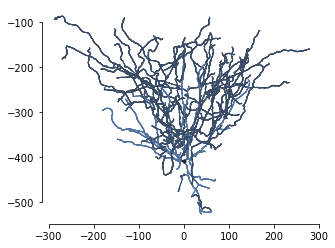

In [31]:
plot_neuron(neighbors, norm_features)